## Importing modules

In [1]:
!pip install surprise
import pandas as pd
import numpy as np
import random
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise import SVD,SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

from surprise.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
from surprise.model_selection.validation import cross_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162996 sha256=d7ab9f80f3d3cc680a4f443385f998af90184db69d2b0d0e8b9f63cc4c28305b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## loading datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
data_list = []

df = pd.read_csv('/content/drive/MyDrive/295A project/Data/marketBias/Data/electronics/df_electronics.csv')

In [4]:
df

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,Etre Jeune,2017,NaN,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,NaN,2017,NaN,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,NaN,2016,NaN,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,NaN,2018,NaN,0


In [5]:
df.isna().sum()

item_id             0
user_id             0
rating              0
timestamp           0
model_attr          0
category            0
brand          961834
year                0
user_attr     1118830
split               0
dtype: int64

In [6]:
df=df.drop(['brand','user_attr'],axis=1)

In [7]:
df.isna().sum()

item_id       0
user_id       0
rating        0
timestamp     0
model_attr    0
category      0
year          0
split         0
dtype: int64

In [8]:
df.dropna(inplace=True)


In [9]:
df.isna().sum()

item_id       0
user_id       0
rating        0
timestamp     0
model_attr    0
category      0
year          0
split         0
dtype: int64

<Axes: title={'center': 'quality'}, ylabel='Frequency'>

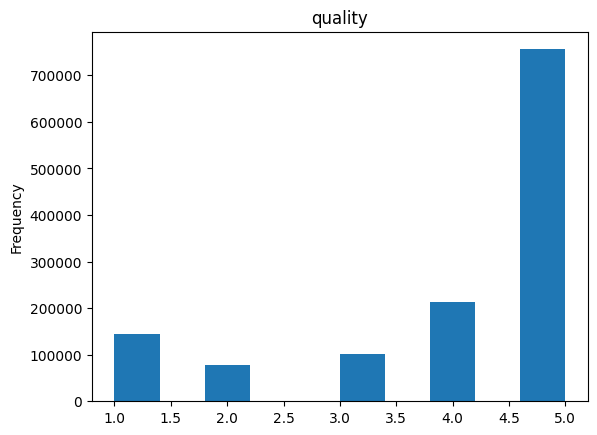

In [10]:
from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', title='quality')
plt.gca()

## Building train and test sets

## Reading the data and creating train test splits

In [11]:
df

,item_id,user_id,rating,timestamp,model_attr,category,year,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,1999,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,1999,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,1999,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,1999,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,1999,0
...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,2017,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,2017,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,2016,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,2018,0


In [12]:
# adding the rating scale of 1 to 10
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id","item_id","rating"]], reader)
raw_ratings = data.raw_ratings

# re arranging the dataset
random.shuffle(raw_ratings)

# splitting the data set into 80:20 training and testing data set
train_test_split_index = int(0.8 * len(raw_ratings))
raw_ratings_train = raw_ratings[:]
raw_ratings_test = raw_ratings[train_test_split_index:]

# constructing the train set
data.raw_ratings = raw_ratings_train  # assign the raw data back

# constructing the test set
testset = data.construct_testset(raw_ratings_test)

## NMF model training and Evaluation

In [13]:
"""
NMF parameters
N_factors: The number of factors.
N_epochs: The number of iterations of the SGD procedure.
lr_all – The learning rate for all parameters.
reg_all – The regularization term for all parameters.
"""

# constructing different parameter with different range of values
### note: these values are changed in the whole process of training to arrive at this specific values based on rmse scores.
NMF_params = {
    "n_factors": [50],
    "n_epochs": [50],
    # "lr_all": [0.005],
    # "reg_all": [0.1]
    }

# using grid search cv with above parameters with cross validation of 3 and refit = True
grid_search = GridSearchCV(
    NMF,
    param_grid = NMF_params,
    measures=["rmse"],
    cv=3,
    refit=True,
    n_jobs=-1,
    joblib_verbose=1
)

# fitting the data
grid_search.fit(data)

# getting best model out of the grid search and best parameters
best_model = grid_search.best_estimator["rmse"]
print(grid_search.best_params)


# pickle the model in case the run time stop in between
import pickle
with open(r"/content/drive/MyDrive/295A project/Data/marketBias/Models/NMF_best_1.pickle", 'wb') as f:
    pickle.dump(best_model, f)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 10.0min finished


{'rmse': {'n_factors': 50, 'n_epochs': 50}}


In [14]:
# a sample prediction to check the model prediction of a user and book
best_model.predict(uid=479149, iid=991397)

# calculating rmse on test set
testset_predictions = best_model.test(testset)
print(accuracy.rmse(testset_predictions))
print(accuracy.mae(testset_predictions))


RMSE: 0.3993
0.39927522136221233
MAE:  0.2329
0.23293635021674966


In [15]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls
def f1_score(precision, recall):
    if precision == 0 and recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from collections import defaultdict



# Compute Precision and Recall at k=10
precisions, recalls = precision_recall_at_k(testset_predictions, k=10, threshold=3.5)

# Average precision and recall over all users
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

# Compute F1-score
f1 = f1_score(avg_precision, avg_recall)

# print(f'RMSE: {rmse}')
print(f'Precision: {avg_precision}')
print(f'Recall: {avg_recall}')
print(f'F1 Score: {f1}')


predictions = [best_model.predict(uid, iid, r_ui=rating) for (uid, iid, rating) in testset]
# Organize predictions by user
user_ratings = defaultdict(list)
for prediction in predictions:
    uid = prediction.uid
    iid = prediction.iid
    est = prediction.est
    r_ui = prediction.r_ui
    user_ratings[uid].append((iid, r_ui, est))

# Sort by actual and predicted ratings to obtain rankings
user_actual_rankings = {}
user_predicted_rankings = {}
for uid, ratings in user_ratings.items():
    user_actual_rankings[uid] = sorted(ratings, key=lambda x: x[1], reverse=True)
    user_predicted_rankings[uid] = sorted(ratings, key=lambda x: x[2], reverse=True)

# Determine item relevance scores
relevancy = {}
from sklearn.metrics import ndcg_score
ndcg_scores=[]
ndcg_penality = -3
for uid in user_actual_rankings:
    actual_rank = {item: idx for idx, (item, _, _) in enumerate(user_actual_rankings[uid])}
    predicted_rank = {item: idx for idx, (item, _, _) in enumerate(user_predicted_rankings[uid])}
    try:
        ndcg_scores.append(ndcg_score(actual_rank.values(),predicted_rank.values()))
    except:
        if list(actual_rank.values())[0]==list(predicted_rank.values())[0]:
            ndcg_scores.append(1)
        else:
            ndcg_scores.append(ndcg_penality)
# Prepare for nDCG calculation
average_ndcg = np.mean(ndcg_scores)
print(f"Average nDCG: {average_ndcg}")

Precision: 0.7506728562575761
Recall: 0.7521371595639876
F1 Score: 0.7514042945191519
Average nDCG: 1.0
